# 05 — Final Modeling Tabular Extra Diagnostics

* Additional diagnostics for RNN architectures:
* skill vs persistence, multi-horizon behaviour and hour-of-day analysis.

## Baselines + Models


In [1]:
from pathlib import Path
import json, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-11-18 10:18:57.946707: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 10:18:57.953294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763479137.960858 3553758 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763479137.963276 3553758 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-18 10:18:57.972209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr


## Config y paths

In [ ]:
# --- Reproducibility ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# --- GPU behavior (prevent TensorFlow from pre-allocating all memory) ---
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

# --- Paths for data, models and figures ---
DATA_CLEAN = Path("../data/clean/base_dataset.csv")
OUT_DIR = Path("../outputs")
ART_DIR = OUT_DIR / "artifacts_keras/latest"
FIG_DIR = OUT_DIR / "figures/latest"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Problem settings ---
TARGET_COL = "GHI"
DEFAULT_INPUT_STEPS   = 36
DEFAULT_HORIZON_STEPS = 6
PATIENCE = 8

TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data

In [ ]:
# --- Load cleaned dataframe (already resampled and feature-engineered) ---
df = pd.read_csv(DATA_CLEAN, parse_dates=[0], index_col=0).sort_index()
df.index.name = "time"

# --- Feature groups (only keep those present in the dataset) ---
base_feats = [
    'Presion','TempAmb','WindSpeed','WindDirection',
    'hour_sin','hour_cos','DoY Sin','DoY Cos',
    'solar_zenith','solar_azimuth','solar_elevation',
    'TempAmb_roll1h_mean','TempAmb_roll6h_mean',
    'Presion_roll1h_mean','Presion_roll6h_mean',
    'WindSpeed_roll1h_mean','WindSpeed_roll6h_mean',
    'temp_pressure_ratio','wind_temp_interaction'
]

ghi_lags  = [c for c in ['GHI_lag1','GHI_lag3','GHI_lag6','GHI_lag12','GHI_lag36'] if c in df.columns]
ghi_rolls = [c for c in ['GHI_roll1h_mean','GHI_roll3h_mean','GHI_roll6h_mean','GHI_roll1h_max'] if c in df.columns]

feat_cols = [c for c in base_feats if c in df.columns] + ghi_lags + ghi_rolls
print(f"Total features used: {len(feat_cols)}")

# --- Train/val/test temporal split ---
assert TARGET_COL in df.columns
n = len(df); i_tr = int(0.7*n); i_va = int(0.85*n)
df_train, df_val, df_test = df.iloc[:i_tr], df.iloc[i_tr:i_va], df.iloc[i_va:]

# --- Scaling: fit only on training ---
X_scaler = StandardScaler(); y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(df_train[feat_cols].values)
X_val   = X_scaler.transform(df_val[feat_cols].values)
X_test  = X_scaler.transform(df_test[feat_cols].values)

y_train = y_scaler.fit_transform(df_train[[TARGET_COL]].values).ravel()
y_val   = y_scaler.transform(df_val[[TARGET_COL]].values).ravel()
y_test  = y_scaler.transform(df_test[[TARGET_COL]].values).ravel()

# --- Median imputation as last safety layer ---
imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X_train)
X_val   = imp.transform(X_val)
X_test  = imp.transform(X_test)

# --- Sanity checks ---
for name, arr in [("X_train",X_train),("X_val",X_val),("X_test",X_test),
                  ("y_train",y_train),("y_val",y_val),("y_test",y_test)]:
    assert np.isfinite(arr).all(), f"{name} contains NaN/Inf"

Total features used: 28


## Helpers

In [ ]:
def _rmse(a, b):
    """RMSE helper on original scale."""
    return float(np.sqrt(mean_squared_error(a, b)))


def build_seq_arrays_with_idx(X_2d, y_1d, idx, L, horizon):
    """
    Build sliding-window sequences (X,y,timestamps) for RNN training and evaluation.
    """
    N, F = X_2d.shape
    outX, outy, out_idx = [], [], []
    last = N - L - horizon + 1

    if last <= 0:
        return (np.zeros((0, L, F), dtype="float32"),
                np.zeros((0,), dtype="float32"),
                np.array([], dtype="datetime64[ns]"))

    for i in range(last):
        block = X_2d[i:i+L]
        if np.isnan(block).any():
            continue
        outX.append(block)
        outy.append(y_1d[i + L + horizon - 1])
        out_idx.append(idx[i + L + horizon - 1])

    return (np.asarray(outX, dtype="float32"),
            np.asarray(outy, dtype="float32"),
            np.array(out_idx))

## Models

In [ ]:
# --- All architectures follow the same signature (L, n_features, ...) ---

def build_lstm(L, n_feat, units=64, layers_n=1, dropout=0.0, bidir=False):
    inp = layers.Input(shape=(L, n_feat))
    x = inp
    for _ in range(layers_n-1):
        cell = layers.LSTM(units, return_sequences=True, dropout=dropout)
        x = layers.Bidirectional(cell)(x) if bidir else cell(x)
    cell = layers.LSTM(units, dropout=dropout)
    x = layers.Bidirectional(cell)(x) if bidir else cell(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)


def build_gru(L, n_feat, units=64, layers_n=1, dropout=0.0, bidir=False):
    inp = layers.Input(shape=(L, n_feat))
    x = inp
    for _ in range(layers_n-1):
        cell = layers.GRU(units, return_sequences=True, dropout=dropout)
        x = layers.Bidirectional(cell)(x) if bidir else cell(x)
    cell = layers.GRU(units, dropout=dropout)
    x = layers.Bidirectional(cell)(x) if bidir else cell(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)


def build_dilated_like(L, n_feat, units=64, dilation=2, dropout=0.0):
    # Temporal subsampling before the recurrent layer
    inp = layers.Input(shape=(L, n_feat))
    x = layers.Lambda(lambda t: t[:, ::dilation, :])(inp)
    x = layers.LSTM(units, dropout=dropout)(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)


def build_clockwork(L, n_feat, hidden=60, modules=3, base_period=1, dropout=0.0):
    # Clockwork RNN: multiple SimpleRNN modules operating at different temporal periods
    assert hidden % modules == 0
    h_per = hidden // modules
    periods = [base_period * (2**m) for m in range(modules)]
    inp = layers.Input(shape=(L, n_feat))
    outs = []
    for p in periods:
        xt = layers.Lambda(lambda t, step=p: t[:, ::step, :])(inp)
        outs.append(layers.SimpleRNN(h_per, activation="tanh", dropout=dropout)(xt))
    h = layers.Concatenate()(outs) if len(outs) > 1 else outs[0]
    out = layers.Dense(1, dtype="float32")(h)
    return models.Model(inp, out)

## Load best saved hyperparameters

In [ ]:
best_params_path = ART_DIR / "tabular_best_params_keras.json"
with open(best_params_path, "r") as f:
    best_params = json.load(f)

print("Loaded models:", best_params.keys())

arch_map = {
    "LSTM_Optuna": "LSTM",
    "GRU_Optuna": "GRU",
    "DilatedRNN_Optuna": "DILATED",
    "ClockworkRNN_Optuna": "CLOCKWORK",
}

rnn_models = list(arch_map.keys())

Keys en best_params: dict_keys(['LSTM_Optuna', 'GRU_Optuna', 'DilatedRNN_Optuna', 'ClockworkRNN_Optuna', 'RF_Optuna'])


## Light training

In [ ]:
def train_fixed_arch_horizon_from_params(model_key, horizon):
    """
    Lightweight re-training of the selected architecture for a specific horizon.
    """
    params = best_params[model_key]
    arch = arch_map[model_key]

    steps  = params.get("input_steps", DEFAULT_INPUT_STEPS)
    dropout = params.get("dropout", 0.0)
    lr  = params.get("lr", 1e-3)
    bs  = params.get("batch", 128)
    eps = min(params.get("epochs", 60), 90)

    # --- Build sequences for train, val, test ---
    Xtr_seq, ytr_seq, _ = build_seq_arrays_with_idx(X_train, y_train, df_train.index.values, steps, horizon)
    Xva_seq, yva_seq, _ = build_seq_arrays_with_idx(X_val,   y_val,   df_val.index.values,   steps, horizon)
    Xte_seq, yte_seq, idx_te = build_seq_arrays_with_idx(X_test,  y_test,  df_test.index.values, steps, horizon)

    if len(Xtr_seq) == 0 or len(Xva_seq) == 0 or len(Xte_seq) == 0:
        raise RuntimeError(f"Empty sequences for {model_key} horizon={horizon}")

    n_feat = Xtr_seq.shape[2]

    # --- Rebuild model ---
    if arch == "LSTM":
        model = build_lstm(steps, n_feat, units=params.get("hidden",64),
                           layers_n=params.get("num_layers",1),
                           dropout=dropout)
    elif arch == "GRU":
        model = build_gru(steps, n_feat, units=params.get("hidden",64),
                          layers_n=params.get("num_layers",1),
                          dropout=dropout)
    elif arch == "DILATED":
        model = build_dilated_like(steps, n_feat,
                                   units=params.get("hidden",64),
                                   dilation=params.get("dilation",2),
                                   dropout=dropout)
    elif arch == "CLOCKWORK":
        model = build_clockwork(steps, n_feat,
                                hidden=params.get("hidden",120),
                                modules=params.get("modules",3),
                                base_period=params.get("base_period",1),
                                dropout=dropout)
    else:
        raise ValueError(arch)

    # --- Training ---
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    cbs = [callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   restore_best_weights=True, verbose=0)]

    model.fit(Xtr_seq, ytr_seq,
              validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    # --- Predictions (inverse-scaled) ---
    yhat = model.predict(Xte_seq, verbose=0).squeeze()
    y_pred = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    y_true = y_scaler.inverse_transform(yte_seq.reshape(-1,1)).ravel()

    return y_true, y_pred, idx_te


def skill_vs_persistence_by_hour(y_true, y_pred, idx_times, horizon):
    """
    Compute hourly RMSE skill vs a persistence baseline.
    """
    df_err = pd.DataFrame({
        "time": idx_times,
        "y_true": y_true,
        "y_pred": y_pred,
    }).set_index("time")

    # Persistence baseline (simple shift)
    base_pred = np.roll(df_err["y_true"].values, horizon)
    if len(base_pred) > horizon:
        base_pred[:horizon] = df_err["y_true"].values[horizon]
    df_err["baseline"] = base_pred
    df_err["hour"] = df_err.index.hour

    rows = []
    for h in range(24):
        sub = df_err[df_err["hour"] == h]
        if len(sub) < 10:
            continue
        rmse_m = _rmse(sub["y_true"], sub["y_pred"])
        rmse_b = _rmse(sub["y_true"], sub["baseline"])
        skill = 1 - rmse_m / (rmse_b + 1e-6)
        rows.append((h, rmse_m, rmse_b, skill))

    return pd.DataFrame(rows, columns=["hour","rmse_model","rmse_base","skill"]).set_index("hour")


def build_skill_matrix_for_model(model_key, horizons=[1,3,6]):
    """
    Build skill matrix: (horizon × hour-of-day) for a given model.
    """
    hours = list(range(24))
    mat = np.full((len(horizons), len(hours)), np.nan)

    for i, h in enumerate(horizons):
        print(f"[{model_key}] horizon {h}")
        y_true, y_pred, idx_te = train_fixed_arch_horizon_from_params(model_key, h)
        stats = skill_vs_persistence_by_hour(y_true, y_pred, idx_te, h)
        for hr in stats.index:
            mat[i, hr] = stats.loc[hr, "skill"]

    return np.array(horizons), np.array(hours), mat


def plot_skill_heatmap(horizons, hours, mat, title, fname=None):
    """
    Heatmap for skill vs. persistence (hour-of-day × horizon).
    """
    plt.figure(figsize=(10,4))
    im = plt.imshow(mat, aspect="auto", origin="lower",
                    extent=[hours[0]-0.5, hours[-1]+0.5,
                            horizons[0]-0.5, horizons[-1]+0.5])
    plt.colorbar(im, label="Skill vs persistence")
    plt.xlabel("Hour of day (issue time)")
    plt.ylabel("Horizon (10-min steps)")
    plt.title(title)
    plt.xticks(hours)
    plt.yticks(horizons)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=160)
    plt.show()


## Compute and Plots


=== Construyendo heatmap para LSTM_Optuna ===
[LSTM_Optuna] Entrenando horizonte 1 pasos...


I0000 00:00:1763479153.628567 3553758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22108 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763479156.390751 3555534 cuda_dnn.cc:529] Loaded cuDNN version 90101


[LSTM_Optuna] Entrenando horizonte 3 pasos...
[LSTM_Optuna] Entrenando horizonte 6 pasos...


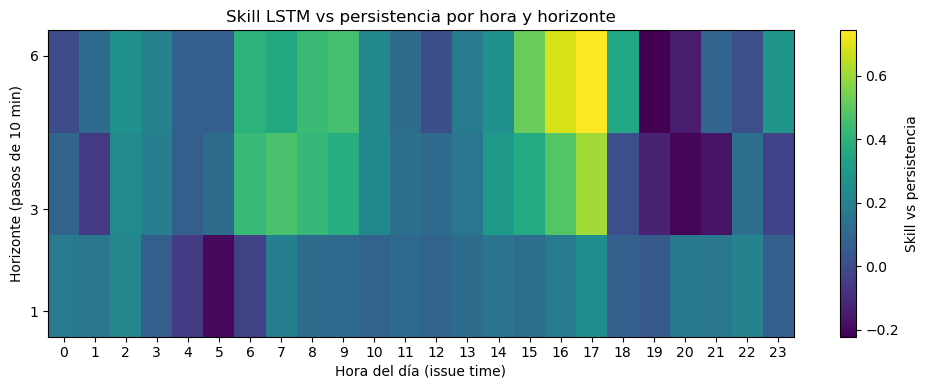


=== Construyendo heatmap para GRU_Optuna ===
[GRU_Optuna] Entrenando horizonte 1 pasos...
[GRU_Optuna] Entrenando horizonte 3 pasos...
[GRU_Optuna] Entrenando horizonte 6 pasos...


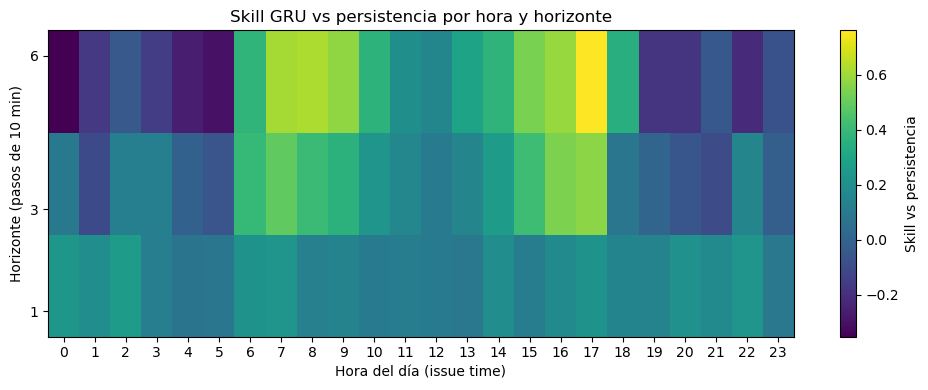


=== Construyendo heatmap para DilatedRNN_Optuna ===
[DilatedRNN_Optuna] Entrenando horizonte 1 pasos...
[DilatedRNN_Optuna] Entrenando horizonte 3 pasos...
[DilatedRNN_Optuna] Entrenando horizonte 6 pasos...


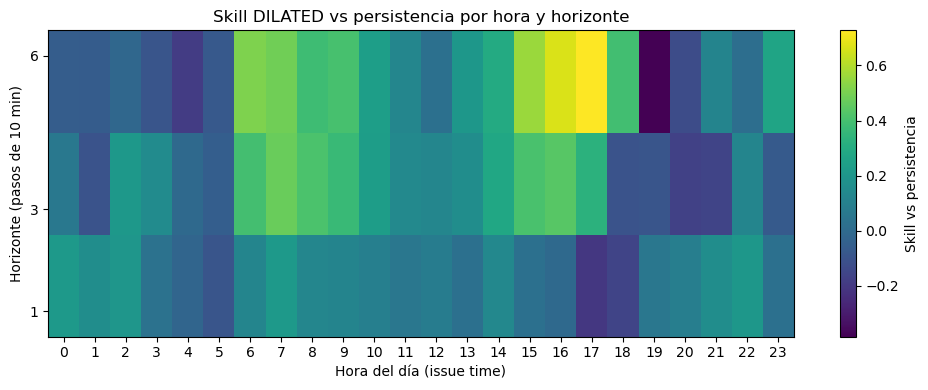


=== Construyendo heatmap para ClockworkRNN_Optuna ===
[ClockworkRNN_Optuna] Entrenando horizonte 1 pasos...


I0000 00:00:1763479562.598739 3555531 service.cc:148] XLA service 0x74241402d330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763479562.598761 3555531 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-18 10:26:02.649958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763479564.663999 3555531 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[ClockworkRNN_Optuna] Entrenando horizonte 3 pasos...
[ClockworkRNN_Optuna] Entrenando horizonte 6 pasos...


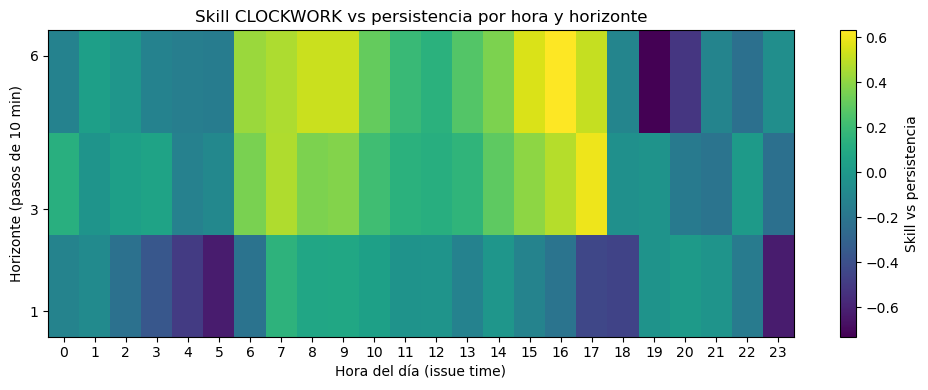

In [ ]:
HORIZONS = [1, 3, 6]

skill_mats = {}

# --- Build heatmaps for each RNN architecture ---
for key in rnn_models:
    print(f"\n=== {key} ===")
    horizons_arr, hours_arr, mat_skill = build_skill_matrix_for_model(key, HORIZONS)
    arch_name = arch_map[key]
    skill_mats[key] = (horizons_arr, hours_arr, mat_skill)
    plot_skill_heatmap(
        horizons_arr, hours_arr, mat_skill,
        f"Skill {arch_name} vs persistence (all horizons)",
        fname=FIG_DIR / f"heatmap_skill_{arch_name.lower()}_allhorizons.png"
    )

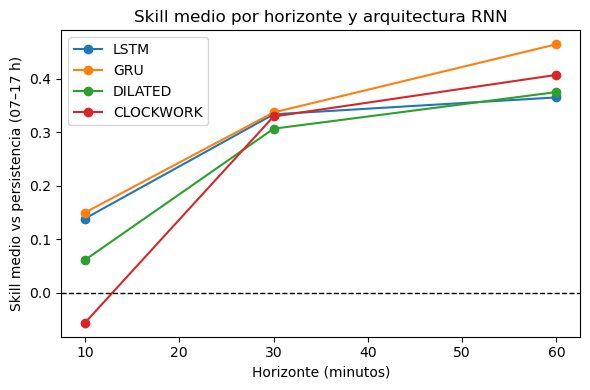

In [ ]:
plt.figure(figsize=(6,4))
for key in rnn_models:
    horizons_arr, hours_arr, mat_skill = skill_mats[key]
    solar_mask = (hours_arr >= 7) & (hours_arr <= 17)
    mean_skill = np.nanmean(mat_skill[:, solar_mask], axis=1)
    plt.plot(horizons_arr*10, mean_skill, marker="o", label=arch_map[key])

plt.axhline(0.0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Horizon (minutes)")
plt.ylabel("Mean skill vs persistence (07–17h)")
plt.title("Mean skill by horizon and RNN architecture")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "skill_mean_by_horizon_rnns.png", dpi=160)
plt.show()